In [1]:
# Librerías

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import *
from scipy.signal import kaiserord, lfilter, firwin, freqz
import scipy.signal as signal
from IPython.display import Audio
from scipy.io.wavfile import read
%matplotlib inline

# 1. Diseño de Filtros con Respuesta Finita al Impulso (FIR)

1. Inicialmente se normalizan las frecuencias de corte, y se pasan a rad/s de acuerdo con la expresion:
$ w_c = 2 \pi · \frac{f_c}{f_s}$

2. Se realiza el mismo procedimiento para el ancho de banda de transición:
$BW_n = 2 \pi · \frac{BW}{f_s} $

3. Una regla práctica para determinar el orden del filtro es dividir 4 por el ancho de banda normalizado y tomar la parte entera del resultado, asi:
$ M = int(\frac{4}{BW_n})$




## 1.1 Procedimiento

In [7]:
'''
1. Implemente un filtro FIR con las siguientes características, de acuerdo a su último número de cédula: 9

Pasa–banda, fc1=1kHz, fc2=4kHz, fs=16 kHz, BW=200Hz, AdB=0
'''

# Características del filtro pasa-banda

N = 512  # Número de puntos para la FFT
fc1 = 1000
fc2 = 4000
fs = 16000
BW = 200
AdB = 0

wc1 = 2 * np.pi * (fc1/fs) # frecuencia de corte 1 normalizada en radianes
wc2 = 2 * np.pi * (fc2/fs) # frecuencia de corte 2 normalizada en radianes
BWn = 2 * np.pi * (BW/fs) # Ancho de banda de transición normalizado en radianes
M = int(4/BWn) # Orden del filtro

print("Orden del filtro pasa-banda: ", M)

Orden del filtro pasa-banda:  50


In [8]:
'''
2. Grafique la respuesta al impulso del filtro asignado (hx de acuerdo con la notación usada).

'''
n = np.arange(-int(M/2), int(M/2)) # Vector para las señales sinc

# Respuesta filtro ideal
h1 = ((wc2/np.pi) * np.sinc((wc2 * n)/np.pi)) - ((wc1/np.pi) * np.sinc((wc1 * n)/np.pi))
h1[n==0]=(wc2-wc1)/np.pi # Se trunca la respuesta en el origen, se evitan singularidades de sinc en n = 0

w1, Hh1 = signal.freqz(h1,1,whole=True, worN = N) # Se calcula la frecuencia del filtro

win1 = signal.windows.hamming(len(n)) # Mitigación del fenómeno de Gibbs con ventana de Hamming

h2 = h1 * win1 # Producto de la respuesta ideal por la ventana

A = np.sqrt(10**(0.1 *AdB))# Ganancia que se desea del filtro

h2 = h2 * A # Respuesta al impulso * Ganancia

w2, Hh2 = signal.freqz(h2,1,whole=True, worN = N) # Respuesta en frecuencia del filtro enventanado

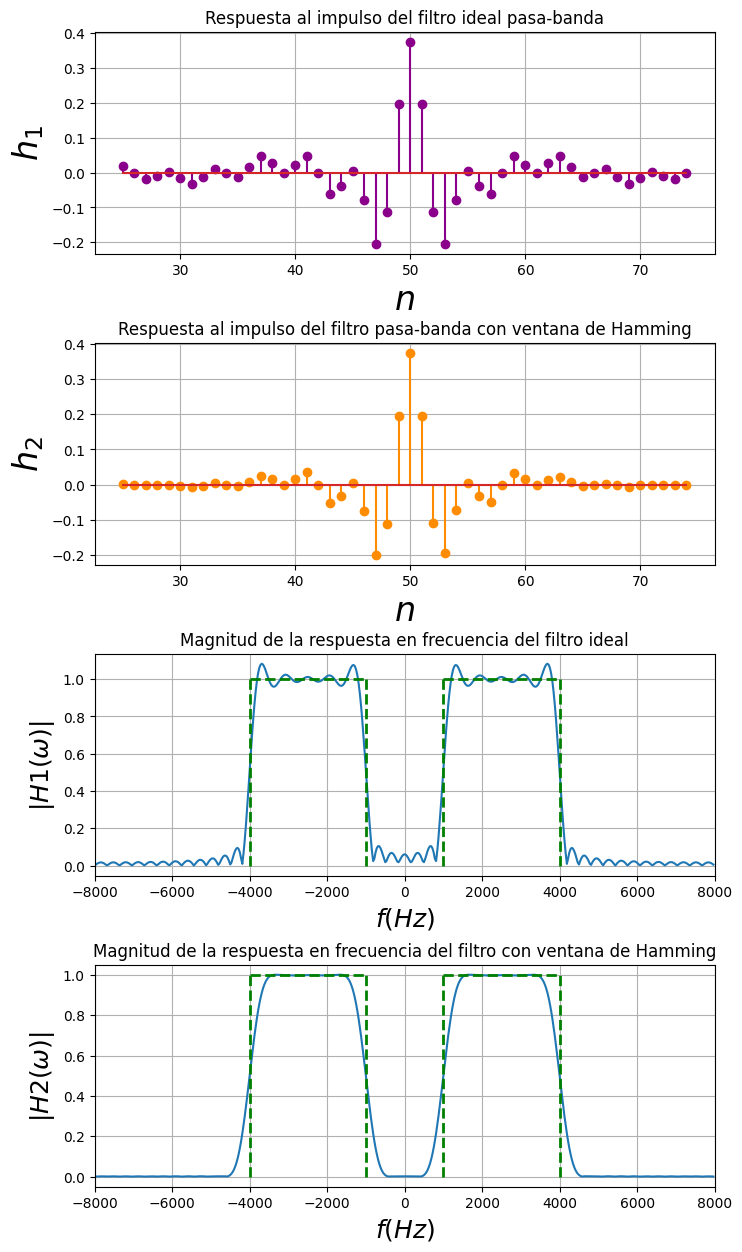

In [9]:
# Gráficas

fig1,axs1 = subplots(4, 1)
fig1.set_size_inches((8, 15))
subplots_adjust(hspace = 0.4)

ax = axs1[0]
ax.stem(n+M, h1, '#8B008B')
ax.set_title("Respuesta al impulso del filtro ideal pasa-banda")
ax.set_xlabel("$n$",fontsize=24)
ax.set_ylabel("$h_1$",fontsize=24)
ax.grid()


ax = axs1[1]
ax.stem(n+M, h2, '#FF8C00')
ax.set_title("Respuesta al impulso del filtro pasa-banda con ventana de Hamming")
ax.set_xlabel("$n$",fontsize=24)
ax.set_ylabel("$h_2$",fontsize=24)
ax.grid()

ax = axs1[2]
ax.plot((w1-np.pi)*fs/(2*np.pi),np.abs(np.fft.fftshift(Hh1)))
ax.axis(xmax=fs/2,xmin=-fs/2)
ax.vlines([-fc1,fc1],0,1,color='g',lw=2.,linestyle='--')
ax.vlines([-fc2,fc2],0,1,color='g',lw=2.,linestyle='--')
ax.hlines(1,-fc2,-fc1,color='g',lw=2.,linestyle='--')
ax.hlines(1,fc1,fc2,color='g',lw=2.,linestyle='--')
ax.set_xlabel(r"$f (Hz)$",fontsize=18)
ax.set_ylabel(r"$|H1(\omega)| $",fontsize=18)
ax.set_title("Magnitud de la respuesta en frecuencia del filtro ideal")
ax.grid()

ax=axs1[3]
ax.plot((w2-np.pi)*fs/(2*np.pi),np.abs(np.fft.fftshift(Hh2)))
ax.axis(xmax=fs/2,xmin=-fs/2)
ax.vlines([-fc1,fc1],0,1,color='g',lw=2.,linestyle='--')
ax.vlines([-fc2,fc2],0,1,color='g',lw=2.,linestyle='--')
ax.hlines(1,-fc2,-fc1,color='g',lw=2.,linestyle='--')
ax.hlines(1,fc1,fc2,color='g',lw=2.,linestyle='--')
ax.set_xlabel(r"$f (Hz)$",fontsize=18)
ax.set_ylabel(r"$|H2(\omega)| $",fontsize=18)
ax.set_title("Magnitud de la respuesta en frecuencia del filtro con ventana de Hamming")
ax.grid()

¿Qué puede observar?

Para la respuesta al impulso, se visualiza en h1 la forma de la señal sinc, tras aplicarle el enventanado, se suavizan las oscilasciones propias de la señal sinc en los extremos de la señal.
El origen de la señal con y sin enventanado está en el valor del orden del filtro.

La ventana de Hamming permite eliminar totalmente las distorsiones causadas por el fenómeno de Gibbs, esto se observa en frecuencia al tener una respuesta en frecuencia de curvas suaves y en el tiempo al disminuir los cambios abruptos sobretodo en los límites izquiero y derecho del filtro.

Al tener un sistema anticausal (tiene coeficientes en ambos lados de n = 0), se busca la causalidad a través de la simetría en los ejes, ya que al desplazar la señal con respecto al origen se vuelve causal y se ve su representación en pasa-bandas, donde no se cambia su magnitud sino su fase.



# 2. Filtrado de música con filtros FIR

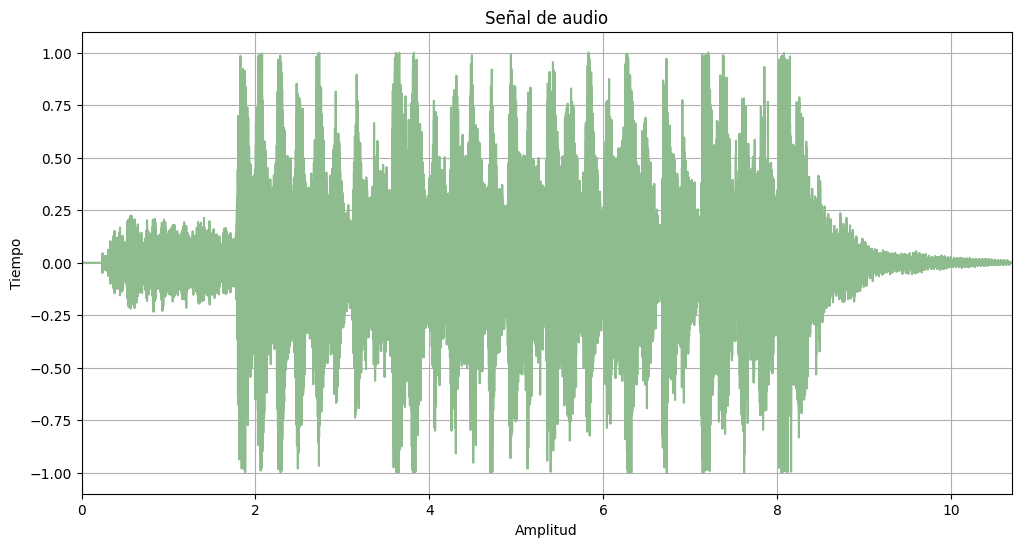

In [11]:
'''
1. Escriba un programa que grafique la señal correspondiente al último número de su cédula (9).
Recuerde, normalizar la señal en amplitud, eliminar su nivel DC y crear su vector de tiempo
dependiendo de la frecuencia de muestreo.

0 y 5: audio5.wav
1 y 6: audio4.wav
2 y 7: audio3.wav
3 y 8: audio2.wav
4 y 9: audio1.wav
'''

# Lectura del audio
audio = ('audio1.wav')
fs, x =  read(audio)



x = x/float(max(abs(x)))  # Normalización
t = np.arange(0,float(len(x))/fs, 1.0/fs) # Vector de tiempo

# Gráfica
plt.figure(figsize=(12, 6))
plt.plot(t, x, '#8FBC8F')
plt.title("Señal de audio")
plt.ylabel("Tiempo")
plt.xlabel("Amplitud")
plt.xlim(0, 10.7)
plt.grid()
plt.show()

# Escuchar el audio
Audio(x, rate=fs)

2. ¿Qué instrumentos logra escuchar en el audio seleccionado?

Xilófono, pandereta, cascabeles

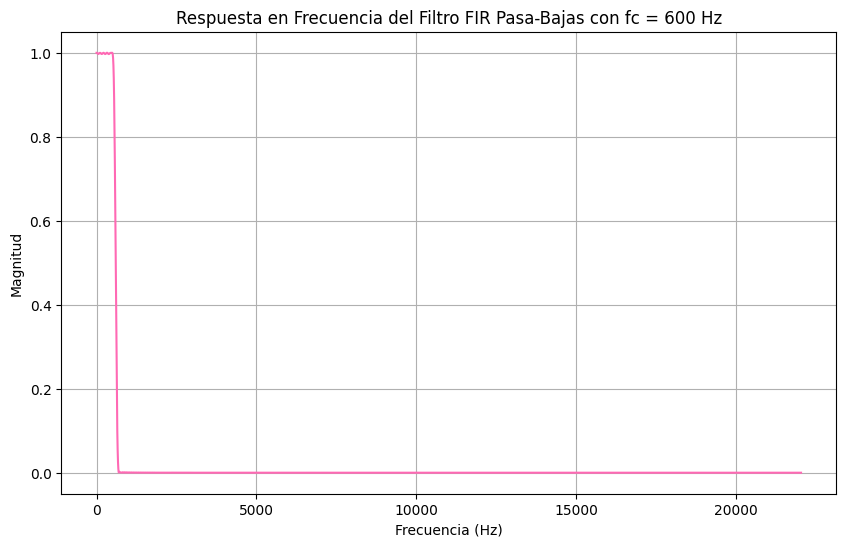

In [12]:
'''
3. Diseñe un filtro FIR pasa-bajas con una banda de transición de 200 Hz, una frecuencia de corte de
600 Hz y un ripple de 60 dB.
Nota: Puede apoyarse del siguiente script que corresponde al diseño de un filtro pasa-altas.
'''
# Parámetros del filtro pasa-bajas
nyq_rate = fs / 2.0 # Frecuencia máxima por nyquist

roll_off = 200.0 # Banda de transición en Hz

cutoff_hz = 600 # Frecuencia de corte

width = roll_off/nyq_rate # Ancho de banda de transición normalizado

ripple_db = 60.0 # Atenuación deseada en la banda de stop, en dB

N,_ = kaiserord(ripple_db, width) # Calcular el orden del filtro y el parámetro de la ventana de Kaiser

taps = firwin(N, cutoff_hz/nyq_rate, pass_zero=True) # Diseño del filto

w, h = signal.freqz(taps, [1], worN=2000) # Respuesta en frecuencia del filtro


# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(nyq_rate * w / np.pi, np.abs(h), '#FF69B4')
plt.title('Respuesta en Frecuencia del Filtro FIR Pasa-Bajas con fc = 600 Hz')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.grid()
plt.show()

In [13]:
'''
4. Pase la señal de audio por el filtro diseñado y escúchela.
Nota: El siguiente script muestra como aplicar un filtro FIR a una señal x.

filtered x = lfilter(taps, 1.0, x)
'''

filteredx = lfilter(taps, 1.0, x)
Audio(filteredx, rate=fs)

5. ¿Qué instrumentos logra escuchar en el audio filtrado?
¿Fue posible separar algunos instrumentos?

Se separó el xilófono aunque el filtro opacó un poco sus sonidos agudos y se nota un tono más grave, tal como si pareciese un piano, pero los demás instrumentos no participan ahora en el audio.

6. Repita los ítems 3 - 6 para frecuencias de corte de 200 Hz y 15000 Hz.

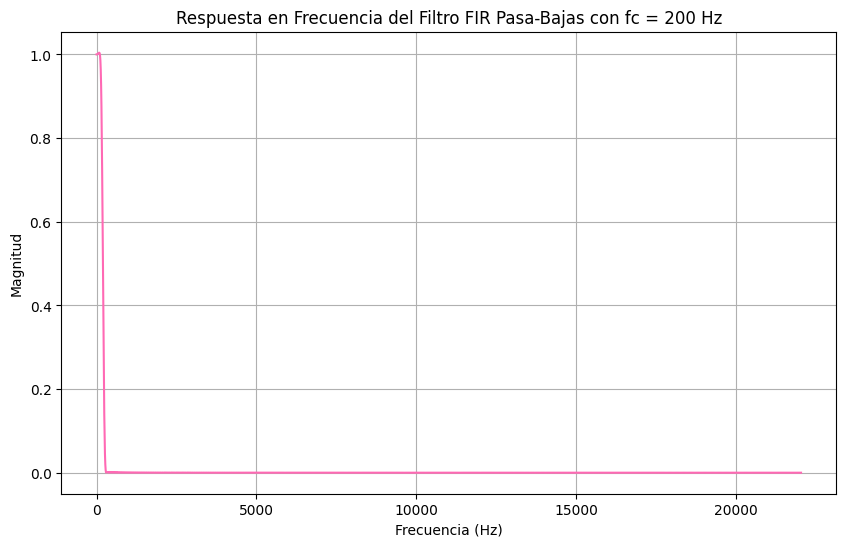

Frecuencia máxima:  22050.0


In [14]:
# Para 200 Hz

# Parámetros del filtro pasa-bajas
nyq_rate = fs / 2.0 # Frecuencia máxima por nyquist

roll_off = 200.0 # Banda de transición en Hz

cutoff_hz = 200 # Frecuencia de corte

width = roll_off/nyq_rate # Ancho de banda de transición normalizado

ripple_db = 60.0 # Atenuación deseada en la banda de stop, en dB

N,_ = kaiserord(ripple_db, width) # Calcular el orden del filtro y el parámetro de la ventana de Kaiser

taps = firwin(N, cutoff_hz/nyq_rate, pass_zero=True) # Diseño del filto

w, h = signal.freqz(taps, [1], worN=2000) # Respuesta en frecuencia del filtro


# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(nyq_rate * w / np.pi, np.abs(h), '#FF69B4')
plt.title('Respuesta en Frecuencia del Filtro FIR Pasa-Bajas con fc = 200 Hz')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.grid()
plt.show()

print("Frecuencia máxima: ", nyq_rate)

In [15]:
filteredx = lfilter(taps, 1.0, x)
Audio(filteredx, rate=fs)

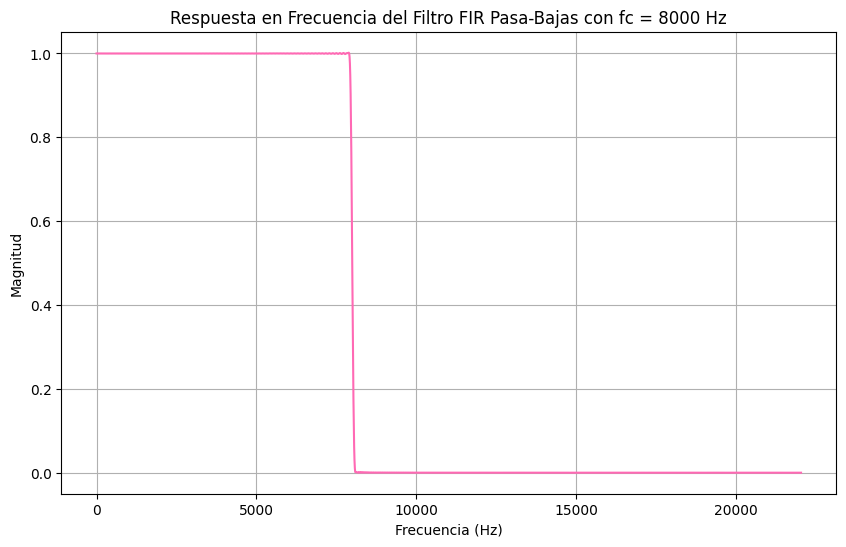

In [18]:
# Para 8000 Hz (no fue posible con 15000 Hz)

# Parámetros del filtro pasa-bajas
nyq_rate = fs / 2.0 # Frecuencia máxima por nyquist

roll_off = 200.0 # Banda de transición en Hz

cutoff_hz = 8000 # Frecuencia de corte

width = roll_off/nyq_rate # Ancho de banda de transición normalizado

ripple_db = 60.0 # Atenuación deseada en la banda de stop, en dB

N,_ = kaiserord(ripple_db, width) # Calcular el orden del filtro y el parámetro de la ventana de Kaiser

taps = firwin(N, cutoff_hz/nyq_rate, pass_zero=True) # Diseño del filto

w, h = signal.freqz(taps, [1], worN=2000) # Respuesta en frecuencia del filtro


# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(nyq_rate * w / np.pi, np.abs(h), '#FF69B4')
plt.title('Respuesta en Frecuencia del Filtro FIR Pasa-Bajas con fc = 8000 Hz')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.grid()
plt.show()

In [17]:
filteredx = lfilter(taps, 1.0, x)
Audio(filteredx, rate=fs)

Para el último caso de una fc = 15.000 Hz no fue posible, pues por nyquist se tiene una frecuencia máxima de 8 KHz, donde al implementarse, permite escuchar todos los instrumentos.


¿Fue posible separar algunos instrumentos en estos casos?, explique.

Al tener una menor frecuencia de corte tal como en 600 o 200 Hz, no se podían escuchar algunos instrumentos, solo el ritmo que marcaba el xilófono, sobretodo para el caso de fc = 200 Hz, donde se escuchaba solamente como si se tuviera el sonido grave del xilófono y estuviera con un sonido tan alto que causara saturación en el audio.

En el caso de fc = 8 KHz sí participan todos los instrumentos, pues estos tienen frecuencias mucho menores a esta (100 Hz para los cascabeles, 349 - 4186 Hz para el xilófono).

# 3. Conclusiones

- Los filtros FIR son ampliamente utilizados e importantes debido a su versatilidad, facilidad de diseño y estabilidad. Su capacidad para controlar la respuesta en frecuencia permite diseñar filtros muy específicos, lo cual es útil en diversas aplicaciones como la eliminación de ruido, la ecualización de audio y la demodulación de señales de comunicación.

- Una de las grandes ventajas de los filtros FIR es que permiten filtrar señales de manera eficiente y con una respuesta en frecuencia muy precisa. Ya que se puede controlar con mucha facilidad el tipo de respuesta al impulso que tienen, y modificarla de acuerdo a las necesidades, tal como se hizo en la práctica que se cambió el desfase pero no la magnitud.

- Por otro lado, el ancho de banda de transición (rango de frecuencias donde ocurre la transición) determinará también el orden del filtro, siendo inversamente proporcionales.
